In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
from collections import defaultdict
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
import simplejson
import urllib
from configobj import ConfigObj

In [7]:
# here we access the webpage and download the content using requests
movie_list=requests.get("http://www.the-numbers.com/movie/budgets/all")

In [8]:
soup = BeautifulSoup(movie_list.text, "html.parser")
datarows = soup.find_all("td", attrs={"class": "data"})
titlerows = soup.find_all("b")[1:]
titles = [row.get_text() for row in titlerows]
titles = titles[:len(titles)-3]

moviedict = {}
for i, title in enumerate(titles):
    vals = datarows[i*4:(i*4)+4]
    newvals = []
    for val in vals:
        exp = r'((?<=\d),(?=\d))|(\$(?=\d))'
        newvals.append(re.sub(exp,r'',val.get_text()))
    moviedict[title] = [int(val) for val in newvals]
    
movieframe = pd.DataFrame.from_dict(moviedict, orient = 'index')
movieframe.columns = ['budget_rank','budget','domestic_gross','worldwide_gross']
movieframe.sort_values('budget_rank', inplace = True)
movieframe = movieframe[movieframe.domestic_gross > 0]
movieframe['dom_profits'] = map(lambda dom, budget: dom - budget, movieframe['domestic_gross'], movieframe['budget'])
movieframe['total_profits'] = map(lambda world, budget: world - budget, movieframe['worldwide_gross'], movieframe['budget'])
movieframe.head()


,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits
Avatar,1,425000000,760507625,2783918982,335507625,2358918982
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425
Spectre,3,300000000,185092708,792592708,-114907292,492592708
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090


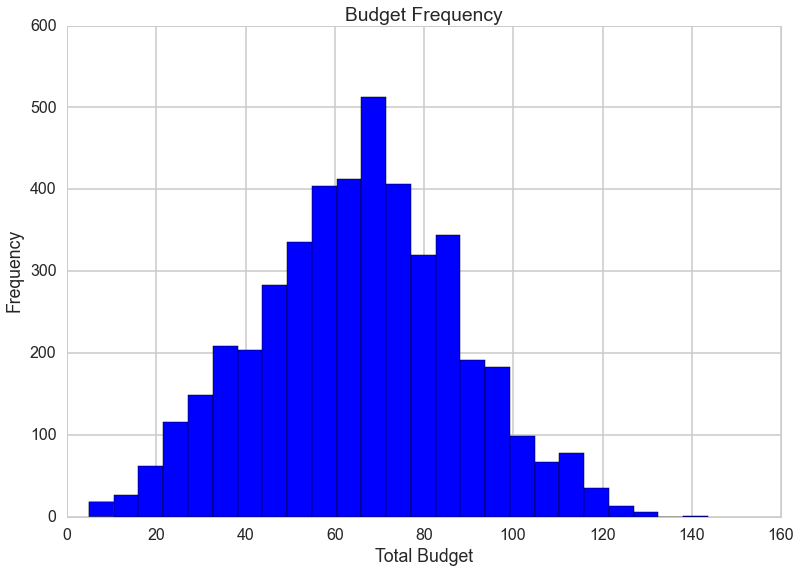

In [9]:
movieframe["budget_quart"] = movieframe['budget'].apply(lambda x : x ** .25)

plt.hist(movieframe["budget_quart"], bins = 25, color = "b")
plt.xlabel("Total Budget")
plt.ylabel("Frequency")
plt.title("Budget Frequency")

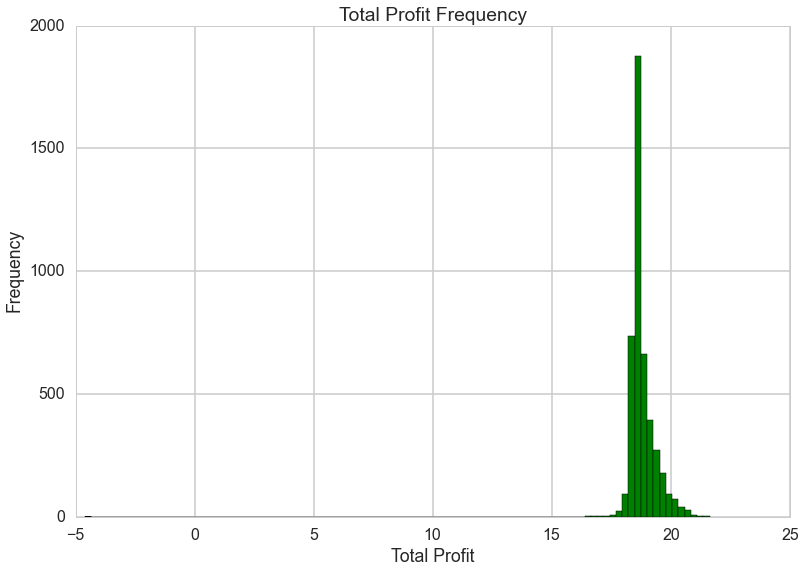

In [10]:
a = np.abs(movieframe["total_profits"].min()) + .01
movieframe["profit_transform"] = movieframe['total_profits'].apply(lambda x : np.log(x + a))

plt.hist(movieframe["profit_transform"], bins = 100, color = "g")
plt.xlabel("Total Profit")
plt.ylabel("Frequency")
plt.title("Total Profit Frequency")

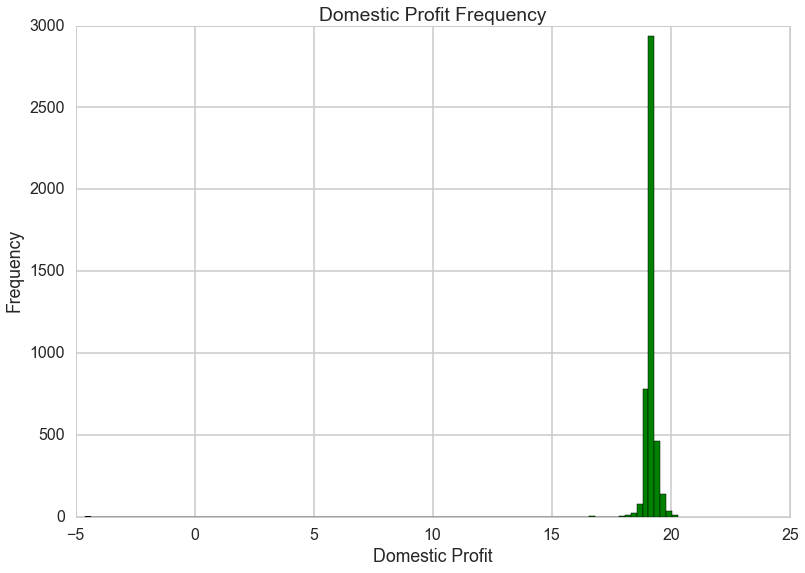

In [11]:
b = np.abs(movieframe["dom_profits"].min()) + .01
movieframe["dom_profit_transform"] = movieframe['dom_profits'].apply(lambda x : np.log(x + b))

plt.hist(movieframe["dom_profit_transform"], bins = 100, color = "g")
plt.xlabel("Domestic Profit")
plt.ylabel("Frequency")
plt.title("Domestic Profit Frequency")

In [131]:
def movie_details(title):
    new_title = title.replace(" ", "+")
    url = "http://api.rottentomatoes.com/api/public/v1.0/movies.json?apikey=dagqdghwaq3e3mxyrp7kmmj5&q=%s&page_limit=2" % (new_title)
    res = requests.get(url)
    time.sleep(.2)
    js = simplejson.loads(res.content)
    if js["movies"] != []:
        movie = js["movies"][0]
        ratings = movie["ratings"]
        if ratings["critics_score"] != -1:
            dates = movie["release_dates"]
            critic_score = ratings["critics_score"]
            aud_score = ratings["audience_score"]
            if "theater" not in dates:
                date = "NA"
                return critic_score, aud_score, date
            else:
                date = dates["theater"]
                return critic_score, aud_score, date
        else:
            movie = js["movies"][1]
            ratings = movie["ratings"]
            dates = movie["release_dates"]
            critic_score = ratings["critics_score"]
            aud_score = ratings["audience_score"]
            if "theater" not in dates:
                date = "NA"
                return critic_score, aud_score, date
            else:
                date = dates["theater"]
                return critic_score, aud_score, date
    else:
        return None, None, None

In [132]:
movies = movieframe.index
movieframe["critic_rating"] = 0
movieframe["aud_rating"] = 0
movieframe["release_date"] = ""

for movie in movies:
    crit, aud, date = movie_details(movie)
    movieframe.loc[movieframe.index.isin([movie]), "critic_rating"] = crit
    movieframe.loc[movieframe.index.isin([movie]), "aud_rating"] = aud
    movieframe.loc[movieframe.index.isin([movie]), "release_date"] = date
    
movieframe

KeyError: 'movies'

In [134]:
movieframe

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,rating,critic_rating,aud_rating,release_date
Avatar,1,425000000,760507625,2783918982,335507625,2358918982,143.581086,21.627229,20.102344,68,0,0,
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425,131.607401,20.466915,19.169082,7,0,0,
Spectre,3,300000000,178416219,751916219,-121583781,451916219,131.607401,20.147664,18.201996,57,0,0,
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099,128.775479,20.639764,19.742651,81,0,0,
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090,128.775479,18.374010,16.602448,44,0,0,
John Carter,6,275000000,73058679,282778100,-201941321,7778100,128.775479,18.588128,-4.605171,100,0,0,
Tangled,7,260000000,200821936,586581936,-59178064,326581936,126.982343,19.895517,18.776698,74,0,0,
Spider-Man 3,8,258000000,336530303,890875303,78530303,632875303,126.737439,20.426645,19.451983,42,0,0,
The Avengers: Age of Ultron,9,250000000,459005868,1404705868,209005868,1154705868,125.743343,20.958461,19.833975,29,0,0,
The Hobbit: An Unexpected Journey,10,250000000,303003568,1017003568,53003568,767003568,125.743343,20.592535,19.356558,56,0,0,


In [23]:
#movieframe.to_csv("movieframe.csv", encoding='utf-8')

In [145]:
# Cleaning up the data, dropping N/As and -1 in the ratings
movieframe = pd.DataFrame.from_csv("movieframe.csv")
movieframe.dropna(inplace = True)
movieframe = movieframe[movieframe['critic_rating'] >= 0]
movieframe = movieframe[movieframe['release_date'] != "NA"]
movieframe

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,rating,critic_rating,aud_rating,release_date
Avatar,1,425000000,760507625,2783918982,335507625,2358918982,143.581086,21.627229,20.102344,68,83,82,2009-12-18
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425,131.607401,20.466915,19.169082,7,45,72,2007-05-25
Spectre,3,300000000,178416219,751916219,-121583781,451916219,131.607401,20.147664,18.201996,57,64,66,2015-11-06
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099,128.775479,20.639764,19.742651,81,87,90,2012-07-20
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090,128.775479,18.374010,16.602448,44,31,51,2013-07-03
John Carter,6,275000000,73058679,282778100,-201941321,7778100,128.775479,18.588128,-4.605171,100,51,60,2012-03-09
Tangled,7,260000000,200821936,586581936,-59178064,326581936,126.982343,19.895517,18.776698,74,90,87,2010-11-24
Spider-Man 3,8,258000000,336530303,890875303,78530303,632875303,126.737439,20.426645,19.451983,42,63,51,2007-05-04
The Avengers: Age of Ultron,9,250000000,459005868,1404705868,209005868,1154705868,125.743343,20.958461,19.833975,29,74,85,2015-05-01
Harry Potter and the Half-Blood Prince,11,250000000,301959197,935083686,51959197,685083686,125.743343,20.494524,19.352453,81,83,77,2009-07-15


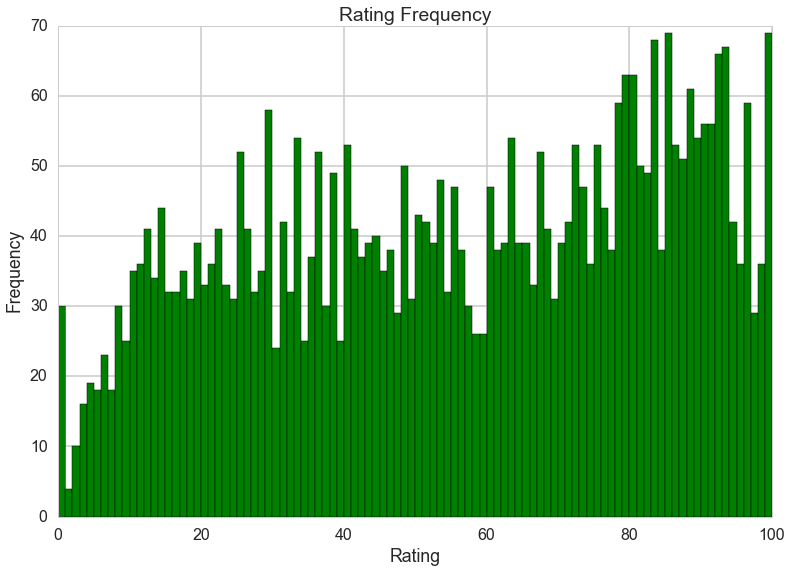

In [146]:
plt.hist(movieframe["critic_rating"], bins = 100, color = "g")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating Frequency")


In [147]:
ols_model = ols("total_profits ~ critic_rating + budget", movieframe).fit()
ols_model
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_profits   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     1199.
Date:                Tue, 08 Dec 2015   Prob (F-statistic):               0.00
Time:                        18:42:37   Log-Likelihood:                -80473.
No. Observations:                4037   AIC:                         1.610e+05
Df Residuals:                    4034   BIC:                         1.610e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -6.123e+07   4.19e+06    -14.621      0.000     -6.94e+07  -5.3e+07
critic_rating   9.83e+05   6.19e+04     15.880      0.000      8.62e+05   1.1e+06
budget            2.0416      0.043     47.329      0.000         1.957     2.126
==============================================================================
Omnibus:                     3183.603   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164766.049
Skew:                           3.325   Prob(JB):                         0.00
Kurtosis:                      33.583   Cond. No.                     1.26e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

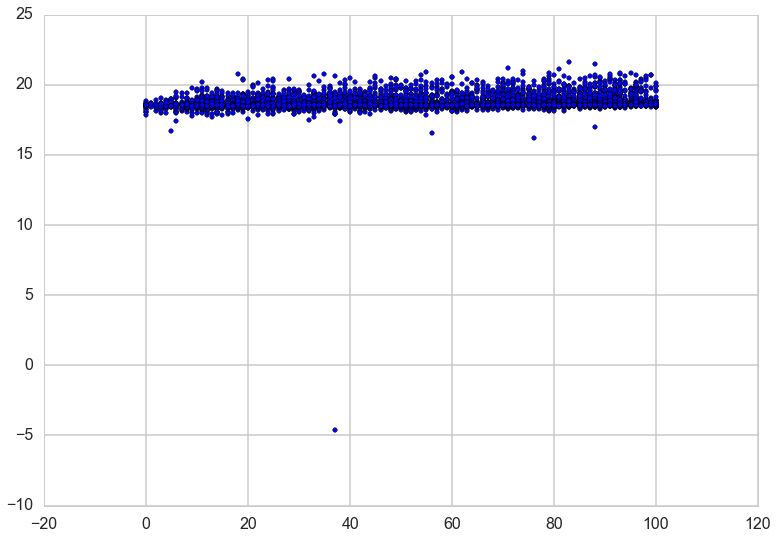

In [150]:
plt.scatter(movieframe["critic_rating"], movieframe["profit_transform"])

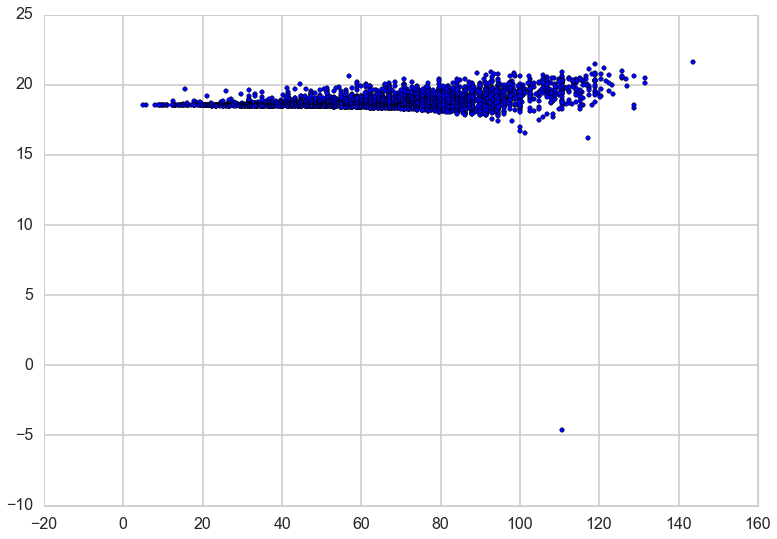

In [149]:
plt.scatter(movieframe["budget_quart"], movieframe["profit_transform"])